## Машинное обучение, ВМК МГУ

## Практическое задание 2

### Общая информация
Дата выдачи: 7 октября 2020

Максимальная оценка: 10 баллов + 1 бонусный балл

Мягкий дедлайн: 23:59MSK 20 октября

Жесткий дедлайн: 23:59MSK 27 октября.

### О задании

В этом задании вы:
- Познакомитесь с методом решения задачи регрессии на основе метода ближайших соседей.
- Реализуете алгоритм kNN для задачи регрессии.
- Изучите методы работы с категориальными и текстовыми переменными.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-02-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-02-ivanov.ipynb).

Далее отправьте этот файл на anytask в соответсвующий раздел.

In [109]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp

Все эксперименты в этой лабораторной работе предлагается проводить на данных соревнования New York City Airbnb Open Data: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data#AB_NYC_2019.csv

В данной задаче предлагается предсказать цену на съем квартиры в зависимости от её параметров.

In [42]:
data = pd.read_csv('AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Сразу исключим колонки 'id' и 'host_id', т.к. это может способствовать переобученности модели. В колонке 'host_id' не все значения уникальны, но они слишком различаются, поэтому не принесут особой пользы.

In [43]:
data = data.drop(columns=['id'])
data = data.drop(columns=['host_id'])

In [44]:
data.shape

(48895, 14)

In [45]:
# число значений у признаков
for col_name in data.columns:
    print(col_name, len(data[col_name].unique()))

name 47906
host_name 11453
neighbourhood_group 5
neighbourhood 221
latitude 19048
longitude 14718
room_type 3
price 674
minimum_nights 109
number_of_reviews 394
last_review 1765
reviews_per_month 938
calculated_host_listings_count 47
availability_365 366


In [46]:
data.isna().sum()

name                                 16
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Как видите, в данных есть пропуски. Не забудьте обработать их

In [47]:
data.fillna({'name': '', 'host_name': '', 'last_review': '', 'reviews_per_month': 0}, inplace=True)

Разобъем данные на обучение и контроль.

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data[['price']],
                                                    test_size=0.3, random_state=241)

## Часть 1: Алгоритм kNN в задаче регрессии

<b> 1.1 (1.5 балла) </b>
Реализуйте класс `KNNRegressor`, который используя метод k ближайших соседей решает задачу регрессии. Для решение данной задачи, необходимо найти $N_k$ - k соседей, и после использовать значения их целевых переменных для предсказания:
\begin{align}
y = \frac{1}{k}\sum_{n \in N_k}w_n y_n,
\end{align}

где $w_n$ - вес каждого соседа. 

При этом `KNNRegressor` может работать в 2 режимах:
 - $uniform$ - ближайшие соседи учитываются с одинаковыми весами.
 - $distance$ - вес ближайших соседей зависит от расстояния
 
**Сигнатуру методов, классов, функции при желании можно менять.**

In [142]:
from typing import Union, Callable, Iterable, Optional
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier


class KNNRegressor:
    def __init__(self, n_neighbors: int, metric: Union[str, Callable], mode: str='uniform', metric_params=None):
        """
        params:
            n_neighbors: number of neighbors
            metric: metric to use for distance computation
            mode: 'uniform' or 'distance'
            'uniform' - all points in each neighborhood are weighted equally
            'distance' - weight points by the inverse of their distance
        """
        self.__nn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, metric_params=metric_params)
        self.__mode = mode
        self.__n_neighbors = n_neighbors
        

    def fit(self, X: np.array, y: np.array) -> None:
        """
            X: data
            y: labels
        """
        self.y = np.array(y)
        self.__nn.fit(X)
        
    def predict(self, X: np.array, n_neighbors: Optional[int] = None):
        """
            X: data
            n_neighbors: number of neighbors
        """
        if n_neighbors == None:
            n = self.__n_neighbors
        else:
            n = n_neighbors
        distance, nearest_neighbors = self.__nn.kneighbors(X, n_neighbors=n)
        i = 0
        predict = np.zeros(X.shape[0])
        for row in nearest_neighbors:
            if self.__mode == 'distance':
                w = list(map(lambda x: 1 / (x + 10 ** (-5)), distance[i]))
                predict[i] = np.sum(self.y[row] * w) / np.sum(w)
            elif self.__mode == 'uniform':
                predict[i] = np.mean(self.y[row])
            i += 1
        return predict

## Часть 2: Категориальные признаки

In [50]:
import sklearn.neighbors
import sklearn.metrics

vbrute = sklearn.neighbors.VALID_METRICS['brute']
vmetrics = sklearn.metrics.pairwise._VALID_METRICS
pairwise = sklearn.metrics.pairwise.PAIRWISE_DISTANCE_FUNCTIONS

def install_metric(f):
    name = f.__name__
    if name not in vbrute:
        vbrute.append(name)
    if name not in vmetrics:
        vmetrics.append(name)

    pairwise[name] = f
    return f

<b>2.1 (1 балл)</b>
Реализуйте три функции расстояния на категориальных признаках _(в этом задании только на них!)_ , которые обсуждались на [втором семинаре](https://github.com/mmp-mmro-team/mmp_mmro_fall_2020/blob/master/seminars/sem02_knn.pdf). Не забудьте, что KNNRegressor должен уметь работать с этими функциями расстояния. Как вариант, можно реализовать метрики как [user-defined distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html).

In [51]:
@install_metric
def overlap(x, z):
    array = []
    x = np.array(x)
    z = np.array(z)
    return ((x[:, None, :] != z[None, :, :])).sum(axis=-1)

@install_metric
def flattened_overlap(x, z, p_array):
    x = np.array(x)
    z = np.array(z)
    dist = np.zeros((x.shape[0], z.shape[0]))
    i = 0
    for elem in x:
        sum_1 = np.sum((elem != z), axis=1)
        p = []
        for j in range(x.shape[1]):
            if elem[j] in p_array[j]:
                p.append(p_array[j][elem[j]])
            else:
                p.append(0)
        sum_2 = np.sum((elem == z) * p, axis=1)
        dist[i] = sum_1 + sum_2
        i += 1
    return np.array(dist)

@install_metric
def log_overlap(x, z, f_x, f_z):
    x = np.array(x)
    z = np.array(z)
    dist = np.zeros((x.shape[0], z.shape[0]))
    i = 0
    for elem in x:
        new_dist = (elem != z) * np.log(f_x[i] + 1) * np.log(f_z[i] + 1)
        dist[i] = np.sum(new_dist, axis = 1)
        i += 1
    return dist

In [52]:
def p_found(x):
    result = []
    for i in range(x.shape[1]):
        uniq, count = np.unique(x[:, i], return_counts=True)
        ind = np.argsort(count)
        uniq = uniq[ind]
        p = count * (count - 1) / x.shape[0] / (x.shape[0] - 1)
        p = np.cumsum(p[ind])
        result.append(dict(zip(uniq, p)))
    return result

<b>2.2 (1 балл)</b> Найдите все категориальные признаки в данных. Подсчитайте для каждой из метрик качество на тестовой выборке `X_test` при числе соседей $k = 10$. Качество измеряйте с помощью RMSE.

Какая функция расстояния оказалась лучшей? Почему?

Еще раз посмотрим на данные и на то, сколько уникальных значений есть в каждом столбце.

In [53]:
for col_name in data.columns:
    print(col_name, len(data[col_name].unique()))

name 47906
host_name 11453
neighbourhood_group 5
neighbourhood 221
latitude 19048
longitude 14718
room_type 3
price 674
minimum_nights 109
number_of_reviews 394
last_review 1765
reviews_per_month 938
calculated_host_listings_count 47
availability_365 366


Из этого сделаем вывод, что категориальными являются признаки host_id, neighbourhood_group, room_type, host_name и neighbourhood.

In [54]:
categorical = ['neighbourhood_group', 'room_type', 'host_name', 'neighbourhood']

In [55]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
enc = enc.fit(data[categorical])
X_categor_train = enc.transform(X_train[categorical])
X_categor_test = enc.transform(X_test[categorical])

In [56]:
regressor = KNNRegressor(n_neighbors=10, metric='overlap', mode='uniform')
regressor.fit(X_categor_train, y_train)
y_pred = regressor.predict(X_categor_test)

In [57]:
np.sqrt(mean_squared_error(y_test, y_pred))

215.36188612194348

In [58]:
f_x = np.zeros(X_categor_train.shape)
f_z = np.zeros(X_categor_train.shape)
i = 0
for elem in X_categor_train:
    f_x[i] = np.sum(X_categor_train == elem, axis=0)
    f_z[i] = np.sum(X_categor_test == elem, axis=0)
    i += 1

In [59]:
p_array = p_found(X_categor_train)

In [60]:
regressor = KNNRegressor(n_neighbors=10, metric='flattened_overlap', mode='uniform', 
                         metric_params={"p_array": p_array})
regressor.fit(X_categor_train, y_train)
y_pred = regressor.predict(X_categor_test)

In [61]:
np.sqrt(mean_squared_error(y_test, y_pred))

208.58447344062247

In [62]:
regressor = KNNRegressor(n_neighbors=10, metric='log_overlap', mode='uniform', metric_params={"f_x": f_x, "f_z": f_z})
regressor.fit(X_categor_train, y_train)
y_pred = regressor.predict(X_categor_test)

In [63]:
np.sqrt(mean_squared_error(y_test, y_pred))

212.20956951422968

Лучшей функцией расстояния оказалась flattened overlap. Это объясняется спецификой наших данных: в качестве категориальных выбраны район и группа районов. В таком случае более редкие признаки дадут больше информации модели.

<b>2.3 (1 балл) бонус</b> Подберите лучшее (на тестовой выборке) число соседей $k$ для каждой из функций расстояния. Какого удалось достичь уровня качества?

In [64]:
for k in range(1, 11):
    regressor = KNNRegressor(n_neighbors=k, metric='overlap', mode='uniform')
    regressor.fit(X_categor_train, y_train)
    y_pred = regressor.predict(X_categor_test)
    print('k = ', k, '\trmse = ', np.sqrt(mean_squared_error(y_test, y_pred)), '\n')

k =  1 	rmse =  267.0569413291095 

k =  2 	rmse =  229.86387326368035 

k =  3 	rmse =  217.2944275416622 

k =  4 	rmse =  235.4118300684533 

k =  5 	rmse =  227.96194832645 

k =  6 	rmse =  227.35013399603537 

k =  7 	rmse =  222.29910805760005 

k =  8 	rmse =  218.44802873776663 

k =  9 	rmse =  216.78002276102873 

k =  10 	rmse =  215.36188612194348 



Пока лучшее качество достигается при k = 10. Проверим, не будет ли роста качества с увеличением числа соседей?

In [65]:
for k in range(10, 110, 10):
    regressor = KNNRegressor(n_neighbors=k, metric='overlap', mode='uniform')
    regressor.fit(X_categor_train, y_train)
    y_pred = regressor.predict(X_categor_test)
    print('k = ', k, '\trmse = ', np.sqrt(mean_squared_error(y_test, y_pred)), '\n')

k =  10 	rmse =  215.36188612194348 

k =  20 	rmse =  209.29323304173462 

k =  30 	rmse =  207.4911002235249 

k =  40 	rmse =  206.56922915744428 

k =  50 	rmse =  206.64073725680288 

k =  60 	rmse =  207.185890450218 

k =  70 	rmse =  207.05492634133265 

k =  80 	rmse =  206.99443033140332 

k =  90 	rmse =  206.90789177372253 

k =  100 	rmse =  206.75601099026204 



Можно заметить, что мы вышли на плато по показателям. Поэтому остановимся на 100 соседях. Удалось достигнуть качества 206.75.

In [66]:
for k in range(1, 11):
    regressor = KNNRegressor(n_neighbors=k, metric='flattened_overlap', mode='uniform', metric_params={"p_array": p_array})
    regressor.fit(X_categor_train, y_train)
    y_pred = regressor.predict(X_categor_test)
    print('k = ', k, '\trmse = ', np.sqrt(mean_squared_error(y_test, y_pred)), '\n')

k =  1 	rmse =  266.1643841280811 

k =  2 	rmse =  227.07152313171358 

k =  3 	rmse =  215.64604598107528 

k =  4 	rmse =  223.25032657918067 

k =  5 	rmse =  218.84009791921335 

k =  6 	rmse =  215.1337565797004 

k =  7 	rmse =  213.33849829948875 

k =  8 	rmse =  210.70617022532568 

k =  9 	rmse =  210.0576553343271 

k =  10 	rmse =  208.58447344062247 



In [67]:
for k in range(20, 110, 10):
    regressor = KNNRegressor(n_neighbors=k, metric='flattened_overlap', mode='uniform', metric_params={"p_array": p_array})
    regressor.fit(X_categor_train, y_train)
    y_pred = regressor.predict(X_categor_test)
    print('k = ', k, '\trmse = ', np.sqrt(mean_squared_error(y_test, y_pred)), '\n')

k =  20 	rmse =  206.66071592239277 

k =  30 	rmse =  205.97057042000063 

k =  40 	rmse =  205.31620979136852 

k =  50 	rmse =  205.22819030409516 

k =  60 	rmse =  205.43542298844238 

k =  70 	rmse =  205.58085307322324 

k =  80 	rmse =  205.6638533467797 

k =  90 	rmse =  205.8867775241738 

k =  100 	rmse =  206.01616974916917 



Видим, что показатели примерно одинаковые. Остановимся на 50 соседях.

In [68]:
for k in range(1, 11):
    regressor = KNNRegressor(n_neighbors=k, metric='log_overlap', mode='uniform', metric_params={"f_x": f_x, "f_z": f_z})
    regressor.fit(X_categor_train, y_train)
    y_pred = regressor.predict(X_categor_test)
    print('k = ', k, '\trmse = ', np.sqrt(mean_squared_error(y_test, y_pred)), '\n')

k =  1 	rmse =  270.3541285608811 

k =  2 	rmse =  231.24643182084458 

k =  3 	rmse =  218.57825026470107 

k =  4 	rmse =  228.10907827010263 

k =  5 	rmse =  221.90256929502056 

k =  6 	rmse =  218.73715615864148 

k =  7 	rmse =  214.80557240783583 

k =  8 	rmse =  213.68440610596846 

k =  9 	rmse =  213.52151940134698 

k =  10 	rmse =  212.20956951422968 



Можно заметить, что при увеличении числа соседей результат стабильно улучшается. 

In [69]:
for k in range(20, 110, 10):
    regressor = KNNRegressor(n_neighbors=k, metric='log_overlap', mode='uniform', metric_params={"f_x": f_x, "f_z": f_z})
    regressor.fit(X_categor_train, y_train)
    y_pred = regressor.predict(X_categor_test)
    print('k = ', k, '\trmse = ', np.sqrt(mean_squared_error(y_test, y_pred)), '\n')

k =  20 	rmse =  212.92184838455847 

k =  30 	rmse =  209.2214823822075 

k =  40 	rmse =  208.32667256898281 

k =  50 	rmse =  207.43814431360596 

k =  60 	rmse =  207.3703508443617 

k =  70 	rmse =  207.2021066822786 

k =  80 	rmse =  206.799046477721 

k =  90 	rmse =  206.53216457948412 

k =  100 	rmse =  206.51977048553368 



Получаем лучший результат при 100 соседях: 162.2.

<b>2.4 (2.5 балла)</b> Отойдем ненадолго от задачи регрессии и перейдём к задаче классификации: будем определять, является ли квартира дорогой $(target = 1)$ или дешевой $(target = 0)$. Будем считать дорогими квариры, цена которых выше среднего.

In [70]:
data['target'] = (data.price > data.price.mean()).astype(int)

Реализуйте счетчики, которые заменят категориальные признаки на вещественные.

А именно, для каждого категориального признака $f_j(x)$ необходимо сделать следующее:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
\begin{align}
counts_j(c) = \sum_{i=1}^l [f_j(x_i) = c]
\end{align}
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
\begin{align}
successes_j(c) = \sum_{i=1}^l[f_j(x_i) = c][y_i = +1].
\end{align}
3. Сглаженное отношение двух предыдущих величин:
\begin{align}
p_j(c) = \frac{successes_j(c) + a}{counts_j(c) + b},
\end{align}

где $a$ и $b$ - априорные счетчики (например, a = 1, b = 2).

In [71]:
def counters(x_train, y, x_test=[], a=1, b=2, test=False):
    """
    params:
        x: value on categorical feature for N objects
    returns: vector of length N
    """
    x_train = np.array(x_train)
    y = np.array(y)
    if test:
        x_test = np.array(x_test)
        mask = x_test[:, None] == x_train
        counts = np.sum(mask, axis=-2)
        successes = np.zeros(x_test.shape)
        i = 0
        for elem in mask:
            successes[i] = np.sum(elem * y[:, None], axis=-2)
            i += 1
        p = (successes + a) / (counts + b)
        return np.hstack((counts, successes, p))
    else:
        mask = x_train[:, None] == x_train
        counts = np.sum(mask, axis=0)
        successes = np.zeros(x_train.shape)
        i = 0
        for elem in mask:
            successes[i] = np.sum(elem * y[:, None], axis=0)
            i += 1
        p = (successes + a) / (counts + b)
        return np.hstack((counts, successes, p))

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанные по всей обучающей выборке. Реализуйте и такой вариант. Достаточно взять $n = 3$.

In [72]:
def fold_counters(x_train, y, x_test=None, a=1, b=2, test=False):
    """
    params:
        x: value on categorical feature for N objects
    returns: vector of length N
    """
    x_train = np.array(x_train)
    y = np.array(y)
    if test:
        return counters(x_train, y, x_test, test=test)
    else:
        step = x.shape[0] // 3
        mask = x_train[:step, None] == x_train[step:]
        counts = np.sum(mask, axis=-2)
        successes = np.zeros(x_train[:step].shape)
        i = 0
        for elem in mask:
            successes[i] = np.sum(elem * y[step:, None], axis=-2)
            i += 1
        p = (successes + a) / (counts + b)
        left = step
        while left < x_train.shape[0]:
            right = left + step
            arr = np.vstack((x_train[:left], x_train[right:]))
            new_y = np.hstack((y[:left], y[right:]))
            mask = x_train[left:right, None] == arr
            new_counts = np.sum(mask, axis=-2)
            new_successes = np.zeros(x_train[left:right].shape)
            i = 0
            for elem in mask:
                new_successes[i] = np.sum(elem * new_y[:, None], axis=-2)
                i += 1
            new_p = (new_successes + a) / (new_counts + b)
            counts = np.vstack((counts, new_counts))
            successes = np.vstack((successes, new_successes))
            p = np.vstack((p, new_p))
            left = right
        return np.hstack((counts, successes, p))

Посчитайте на тесте AUC-ROC метода $k$ ближайших соседей с евклидовой метрикой для выборки, где категориальные признаки заменены на счетчики. Сравните по AUC-ROC два варианта формирования выборки — с фолдингом и без. Не забудьте подобрать наилучшее число соседей $k$.

In [73]:
X_clas_train, X_clas_test, y_clas_train, y_clas_test = train_test_split(data.drop(columns=['price']), data['target'],
                                                    test_size=0.3, random_state=241)

In [74]:
X_train_count = counters(X_clas_train[categorical], y_clas_train)

In [75]:
X_test_count = counters(X_clas_train[categorical], y_clas_train, X_clas_test[categorical], test=True)

In [76]:
for k in range(10, 110, 10):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train_count, y_clas_train)
    y_pred = neigh.predict(X_test_count)
    print('k = ', k, '\taccuracy = ', np.sqrt(accuracy_score(y_clas_test, y_pred)), '\n')

k =  10 	accuracy =  0.8848410154403414 

k =  20 	accuracy =  0.8905239618223993 

k =  30 	accuracy =  0.8908301153206826 

k =  40 	accuracy =  0.8915568085351917 

k =  50 	accuracy =  0.8942290036346624 

k =  60 	accuracy =  0.8952956484758736 

k =  70 	accuracy =  0.8974631154701693 

k =  80 	accuracy =  0.8977669026043569 

k =  90 	accuracy =  0.8987155755475786 

k =  100 	accuracy =  0.8989810245724956 



С увеличением соседей качество постепенно растет, а затем остается примерно на одинаковом уровне. Построим AUC-ROC для 100 соседей.

In [77]:
neigh = KNeighborsClassifier(n_neighbors=100)
neigh.fit(X_train_count, y_clas_train)
y_pred = neigh.predict(X_test_count)

In [78]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_clas_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

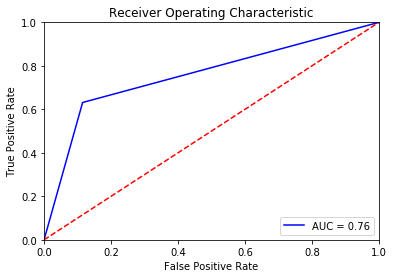

In [79]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [80]:
X_train_fold_count = fold_counters(X_clas_train[categorical], y_clas_train)

In [81]:
X_test_fold_count = fold_counters(X_clas_train[categorical], y_clas_train, X_clas_test[categorical], test=True)

In [82]:
for k in range(10, 110, 10):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train_fold_count, y_clas_train)
    y_pred = neigh.predict(X_test_fold_count)
    print('k = ', k, '\taccuracy = ', np.sqrt(accuracy_score(y_clas_test, y_pred)), '\n')

k =  10 	accuracy =  0.8804386018947145 

k =  20 	accuracy =  0.8832602180109232 

k =  30 	accuracy =  0.88576505121431 

k =  40 	accuracy =  0.8839545747554564 

k =  50 	accuracy =  0.8841088021970479 

k =  60 	accuracy =  0.8838774509430026 

k =  70 	accuracy =  0.8839160136903844 

k =  80 	accuracy =  0.8834917308936753 

k =  90 	accuracy =  0.882333559020345 

k =  100 	accuracy =  0.8834145666740517 



Построим AUC-ROC для 100 соседей:

In [83]:
fpr, tpr, threshold = metrics.roc_curve(y_clas_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

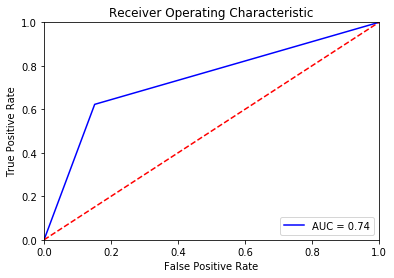

In [84]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<b>2.5 (1 балл)</b> Вернемся к задаче регрессии. Утверждается, что для задачи регрессии можно также сделать преобразование категориальных признаков в действительные числа. Для этого достаточно для каждого значения признака $f_j$ вычислить:
\begin{align}
p_j(c) = g(T_i | f_j(x_i) = c),
\end{align}

где $T_i$ - значения целевой переменной объекта $x_i$. Функция $g$ - среднее (mean) или среднеквадратичное отклонение (std).

Закодируйте категориальные признаки обоими способами и найдите значение RMSE. Используйте евклидову метрику для поиска ближайших соседей. Для какой функции $g$ значение RMSE лучше? Почему?

In [85]:
x = np.array(X_train[categorical])
y = np.array(y_train)

In [86]:
x_test = np.array(X_test[categorical])

In [87]:
p_mean = np.zeros(x.shape)
p_std = np.zeros(x.shape)
i = 0
for elem in x:
    p_mean[i] = np.mean((elem == x) * y, axis=0)
    p_std[i] = np.std((elem == x) * y, axis=0)
    i += 1

In [88]:
p_mean_test = np.zeros(x_test.shape)
p_std_test = np.zeros(x_test.shape)
i = 0
for elem in x_test:
    p_mean_test[i] = np.mean((elem == x) * y, axis=0)
    p_std_test[i] = np.std((elem == x) * y, axis=0)
    i += 1

In [89]:
for k in range(20, 110, 10):
    regressor = KNNRegressor(n_neighbors=k, metric='euclidean', mode='uniform')
    regressor.fit(p_mean, y_train)
    y_pred = regressor.predict(p_mean_test)
    print('k = ', k, '\trmse = ', np.sqrt(mean_squared_error(y_test, y_pred)), '\n')

k =  20 	rmse =  213.458904299475 

k =  30 	rmse =  211.95172667605271 

k =  40 	rmse =  211.06940095343225 

k =  50 	rmse =  210.8097742286993 

k =  60 	rmse =  210.5711069005607 

k =  70 	rmse =  210.328160274706 

k =  80 	rmse =  210.173259153049 

k =  90 	rmse =  209.91685077359264 

k =  100 	rmse =  209.65632345959952 



In [90]:
for k in range(20, 110, 10):
    regressor = KNNRegressor(n_neighbors=k, metric='euclidean', mode='uniform')
    regressor.fit(p_std, y_train)
    y_pred = regressor.predict(p_std_test)
    print('k = ', k, '\trmse = ', np.sqrt(mean_squared_error(y_test, y_pred)), '\n')

k =  20 	rmse =  212.6853429449709 

k =  30 	rmse =  211.60510857989632 

k =  40 	rmse =  211.12434410330803 

k =  50 	rmse =  211.13792996693078 

k =  60 	rmse =  211.37852067236184 

k =  70 	rmse =  211.14844111078224 

k =  80 	rmse =  210.93229221133586 

k =  90 	rmse =  210.9903155967877 

k =  100 	rmse =  210.87860133932293 



Значение g оказалось лучше для g = mean, т.к. для средняя квадратичная ошибка как раз подразумевает поиск среднего. Кодирование средним значением сильнее приближает нас к целевой переменной. 

## Часть 3: Текстовые признаки

<b>3.1 (2 балла)</b> Перейдем от категориальным признакам к текстовым. Рассмотрим 2 способа преобразования текста в действительные числа:
- Мешок слов (Bag of Words)
- TF-IDF

[Здесь](https://scikit-learn.org/stable/modules/feature_extraction.html) вы можете прочитать про их применение в Питоне.

Сравните оба способа на задаче регрессии. Какую лучше метрику использовать: евклидову или косинусную меру? Постройте графики зависимости качества решения задачи от способа преобразования, метрики и количества соседей. Мера качества - RMSE.

Объясните полученные результаты.

Перед преобразованием не забудьте уменьшить размер словаря. Например, это можно сделать за счет приведения всех слов к одному регистру и удаления [стопслов](https://en.wikipedia.org/wiki/Stop_words) (артиклей, предлогов, союзов). Можно использовать использовать, например, библиотеку nltk.

In [91]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [92]:
count_vect = CountVectorizer(lowercase=True, stop_words='english')
X_train_counts = count_vect.fit_transform(X_train['name'])

In [93]:
tfidfVect = TfidfVectorizer(lowercase=True, stop_words='english')
X_train_tfidf = tfidfVect.fit_transform(X_train['name'])

In [94]:
X_test_counts = count_vect.transform(X_test['name'])
X_test_tfidf = tfidfVect.transform(X_test['name'])

In [95]:
euclid_counts_accur = []
for k in range(1, 11):
    regressor = KNNRegressor(n_neighbors=k, metric='euclidean', mode='uniform')
    regressor.fit(X_train_counts, y_train)
    y_pred = regressor.predict(X_test_counts)
    accur = np.sqrt(mean_squared_error(y_test, y_pred))
    euclid_counts_accur.append(accur)
    print('k = ', k, '\trmse = ', accur, '\n')

k =  1 	rmse =  257.3701278544993 

k =  2 	rmse =  236.08641248015022 

k =  3 	rmse =  225.52112463488854 

k =  4 	rmse =  226.69035989887587 

k =  5 	rmse =  224.39243548282906 

k =  6 	rmse =  220.14594016287046 

k =  7 	rmse =  218.1031592741917 

k =  8 	rmse =  216.62888067801597 

k =  9 	rmse =  215.46166109922424 

k =  10 	rmse =  214.77902895349382 



In [96]:
cosine_counts_accur = []
for k in range(1, 11):
    regressor = KNNRegressor(n_neighbors=k, metric='cosine', mode='uniform')
    regressor.fit(X_train_counts, y_train)
    y_pred = regressor.predict(X_test_counts)
    accur = np.sqrt(mean_squared_error(y_test, y_pred))
    cosine_counts_accur.append(accur)
    print('k = ', k, '\trmse = ', accur, '\n')

k =  1 	rmse =  267.6856884229871 

k =  2 	rmse =  238.36468371359933 

k =  3 	rmse =  226.10092309168041 

k =  4 	rmse =  224.66516724267566 

k =  5 	rmse =  217.58416250466004 

k =  6 	rmse =  214.02143364050318 

k =  7 	rmse =  213.5279865962538 

k =  8 	rmse =  212.5072168801938 

k =  9 	rmse =  211.50686546885615 

k =  10 	rmse =  209.08964680779567 



In [97]:
euclid_tfidf_accur = []
for k in range(1, 11):
    regressor = KNNRegressor(n_neighbors=k, metric='euclidean', mode='uniform')
    regressor.fit(X_train_tfidf, y_train)
    y_pred = regressor.predict(X_test_tfidf)
    accur = np.sqrt(mean_squared_error(y_test, y_pred))
    euclid_tfidf_accur.append(accur)
    print('k = ', k, '\trmse = ', accur, '\n')

k =  1 	rmse =  323.04078297863316 

k =  2 	rmse =  269.23202918846164 

k =  3 	rmse =  245.4302343782814 

k =  4 	rmse =  231.01285354122865 

k =  5 	rmse =  222.63192067724233 

k =  6 	rmse =  220.3371581068209 

k =  7 	rmse =  218.04667008737874 

k =  8 	rmse =  216.21790362794997 

k =  9 	rmse =  215.11857254585973 

k =  10 	rmse =  214.2738805816425 



In [98]:
cosine_tfidf_accur = []
for k in range(1, 11):
    regressor = KNNRegressor(n_neighbors=k, metric='cosine', mode='uniform')
    regressor.fit(X_train_tfidf, y_train)
    y_pred = regressor.predict(X_test_tfidf)
    accur = np.sqrt(mean_squared_error(y_test, y_pred))
    cosine_tfidf_accur.append(accur)
    print('k = ', k, '\trmse = ', accur, '\n')

k =  1 	rmse =  330.71578348038236 

k =  2 	rmse =  272.29655127799435 

k =  3 	rmse =  247.07931838966368 

k =  4 	rmse =  231.49075663031653 

k =  5 	rmse =  221.93814893744627 

k =  6 	rmse =  217.48698430917617 

k =  7 	rmse =  215.6790875334434 

k =  8 	rmse =  212.60937574159635 

k =  9 	rmse =  210.6193761579025 

k =  10 	rmse =  209.68379239455956 



In [99]:
k_list = np.arange(1, 11)

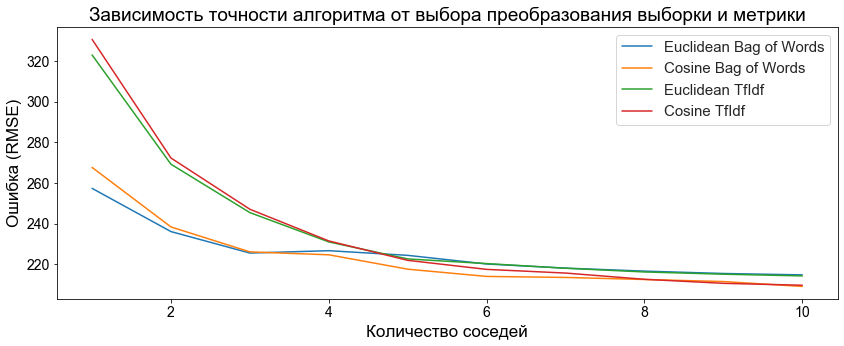

In [100]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title("Зависимость точности алгоритма от выбора преобразования выборки и метрики", fontsize = 19)
plt.xlabel("Количество соседей", fontsize = 17) 
plt.ylabel("Ошибка (RMSE)", fontsize = 17) 
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
ax1.plot(k_list, euclid_counts_accur, label = "Euclidean Bag of Words")
ax1.plot(k_list, cosine_counts_accur, label = "Cosine Bag of Words")
ax1.plot(k_list, euclid_tfidf_accur, label = "Euclidean TfIdf")
ax1.plot(k_list, cosine_tfidf_accur, label = "Cosine TfIdf")
ax1.legend(fontsize = 15)

In [101]:
cosine_counts_accur = []
for k in range(20, 110, 10):
    regressor = KNNRegressor(n_neighbors=k, metric='cosine', mode='uniform')
    regressor.fit(X_train_counts, y_train)
    y_pred = regressor.predict(X_test_counts)
    accur = np.sqrt(mean_squared_error(y_test, y_pred))
    cosine_counts_accur.append(accur)

In [102]:
cosine_tfidf_accur = []
for k in range(20, 110, 10):
    regressor = KNNRegressor(n_neighbors=k, metric='cosine', mode='uniform')
    regressor.fit(X_train_tfidf, y_train)
    y_pred = regressor.predict(X_test_tfidf)
    accur = np.sqrt(mean_squared_error(y_test, y_pred))
    cosine_tfidf_accur.append(accur)

In [103]:
k_list = np.arange(20, 110, 10)

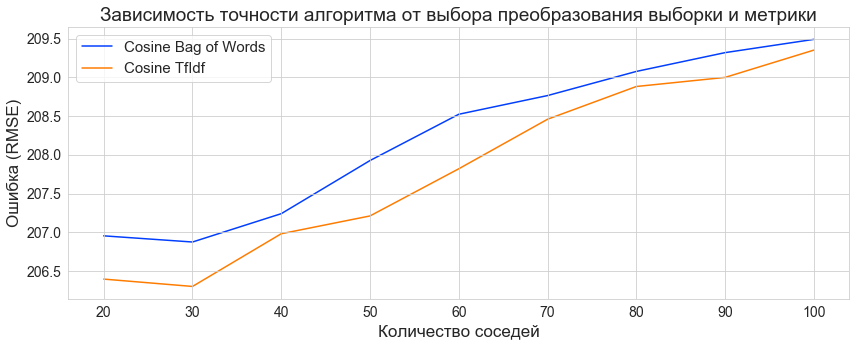

In [104]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title("Зависимость точности алгоритма от выбора преобразования выборки и метрики", fontsize = 19)
plt.xlabel("Количество соседей", fontsize = 17) 
plt.ylabel("Ошибка (RMSE)", fontsize = 17) 
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
ax1.plot(k_list, cosine_counts_accur, label = "Cosine Bag of Words")
ax1.plot(k_list, cosine_tfidf_accur, label = "Cosine TfIdf")
ax1.legend(fontsize = 15)

Получаем лучший результат при использовании Cosine Tfidf и 30 соседях. Этот результат  логичен, т.к. при использовании cosine метрики учитывается похожесть текста независимо от его длины. А Tfidf учитывает частоту слова, т.е. как часто слово встречается в тексте. Для более точного предсказания интересны более редкие слова, и Tfidf как раз позволяет это использовать.

<b>3.2 (1 балл)</b> Используя все доступные признаки, решите задачу регрессии. Для категориальных и текстовых признаков выберите лучшие преобразования (из сделанных раннее заданий). Повлияло ли добавление количественного признака на метрику качества?

In [105]:
numeric = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data[['price']], 
                                                    test_size=0.3, random_state=241)
X_train_numeric = np.array(X_train[numeric])
X_test_numeric = np.array(X_test[numeric])

In [106]:
x = np.array(X_train[categorical])
p_mean = np.zeros(x.shape)
i = 0
for elem in x:
    p_mean[i] = np.mean((elem == x) * y, axis=0)
    i += 1

In [107]:
x_test = np.array(X_test[categorical])
p_mean_test = np.zeros(x_test.shape)
i = 0
for elem in x_test:
    p_mean_test[i] = np.mean((elem == x) * y, axis=0)
    p_std_test[i] = np.std((elem == x) * y, axis=0)
    i += 1

In [108]:
X_train_tfidf = tfidfVect.fit_transform(X_train['name'])
X_test_tfidf = tfidfVect.transform(X_test['name'])

In [114]:
print(X_train_numeric.shape)
print(X_train_tfidf.shape)
print(p_mean.shape)

(34226, 5)
(34226, 6430)
(34226, 4)


In [111]:
X_train_all = sp.hstack((X_train_tfidf, X_train_numeric, p_mean), format='csr')
X_test_all = sp.hstack((X_test_tfidf, X_test_numeric, p_mean_test), format='csr')

In [116]:
X_test_all.shape

(14669, 6439)

In [143]:
regressor = KNNRegressor(n_neighbors=100, metric='euclidean', mode='distance')
regressor.fit(X_train_all, y_train)

In [144]:
y_pred = regressor.predict(X_test_all)

In [145]:
accur = np.sqrt(mean_squared_error(y_test, y_pred))
accur

17395.5092913924

Использование количественных признаков позволило понизить ошибку, но незначительно.

## Часть 4: Выводы


В данной работе были проанализированы различные преобразования категориальных и тестовых признаков, рассмотрены различные метрики и способы кодирования категориальных признаков. В результате было выявлено, что для категориальных признаков наивысшее качество показала метрика flattened_overlap, т.к. она позволяет учитывать частоту встреченных эелементов. 
Преобразование категриальных признаков в вещественные лучше выполнять с использованием функции mean, т.к. усреденный результат повышает качество предсказания.
Для исследования текстовых признаков лучше всего использовать TF-IDF и косинусную метрику, т.к. первый параметр позволяет учитывать частоту встреченных слов (более редкие слова имеют более высокую важность для прогноза), а косинусная метрика позволяет не учитывать размер текста при исследовании его "похожести".
Общий анализ показал, что для этой задачи knn оказался не самым эффективным алгоритмом, и RMSE все равно остается в окрестностях 200.